**Pendahuluan**
- dalam proyek in fokus utama adalah cleaning atau preparation dataset pada transaksi yang sukses ( seperti penanganan missing value dan sebagainya)

- fokus utama dataset ialah
1.  olist_orders_dataset.csv -> Data Master Pesanan (Tanggal, Status, ID)
2. olist_order_items_dataset.csv -> Detail produk di setiap pesanan
3. olist_products_dataset.csv -> Detail Produk (Nama Kategori, ID)
4. product_category_name_translation.csv -> Kamus Terjemahan Kategori (Português $\rightarrow$ English)

-----

**import dataset**

In [111]:
import pandas as pd

# dataPesanan
df_orders = pd.read_csv('olist_orders_dataset.csv')
# dataDetailProduk_setiap pesanan
df_orders_items = pd.read_csv('olist_order_items_dataset.csv')


# Lihat 5 baris pertama_orders_Pesanan
print(df_orders.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

----

**merge table untuk memperkaya insight**

In [112]:
# Gabungkan Orders (Kiri) dengan Order Items (Kanan)
# Gunakan how='left' untuk melihat apakah ada order yang tidak punya item
df_merged = df_orders.merge(df_orders_items, on='order_id', how='left')

# Cek apakah ada "Kotoran" (Order tanpa item)
if df_merged['product_id'].isnull().sum() > 0:
    print("Ada order tanpa item. Periksa data lebih lanjut. we got first dirty data")
else:
    print("Semua order punya item. Data bersih dari order tanpa item.")
 
print('=='*40)
print("Jumlah Order tanpa Item:", df_merged['product_id'].isnull().sum())
print('=='*40)
print(df_merged['order_status'].unique())

Ada order tanpa item. Periksa data lebih lanjut. we got first dirty data
Jumlah Order tanpa Item: 775
['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


----

**Hitung jumlah statusnya dan melihat distribusinya**

In [113]:
# Ambil hanya data yang 'product_id'-nya kosong (NaN)
df_orders_no_items = df_merged[df_merged['product_id'].isnull()]

# Hitung jumlah statusnya dan melihat distribusinya
print(df_orders_no_items['order_status'].value_counts())

order_status
unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: count, dtype: int64


---
**(Drop Rows)**

- an insight -> tujuan kita biasanya ingin menganalisis "Penjualan" (Revenue/Sales), order yang tidak ada barangnya (artinya tidak ada harganya) adalah SAMPAH atau hanya mengambil data yang benar2 terjual.

In [114]:
# RINGKAS ambil yang benar benar delivered (Whitelisting)
# Daripada membuang sampah satu-satu, ambil saja berliannya.
df_clean_final = df_merged[df_merged['order_status'] == 'delivered']

print(df_clean_final['order_status'].value_counts())

print('=='*40)

print(df_clean_final.head(5))

order_status
delivered    110197
Name: count, dtype: int64
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 2

----
**Double Merge untuk mengubah kode product_id $\rightarrow$ Nama Portugis $\rightarrow$ Nama Inggris.**

In [115]:
# dataProduk
df_products = pd.read_csv('olist_products_dataset.csv')

print(df_products.head())


                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0       

In [116]:
# Tempelkan Nama Portugis ke Data Transaksi
# merge ke df_clean_final yang sudah di whitelis
df_step1 = pd.merge(df_clean_final, df_products, on='product_id', how='left')
print(df_step1[['order_id', 'order_status', 'product_category_name']].head())


                           order_id order_status  product_category_name
0  e481f51cbdc54678b7cc49136f2d6af7    delivered  utilidades_domesticas
1  53cdb2fc8bc7dce0b6741e2150273451    delivered             perfumaria
2  47770eb9100c2d0c44946d9cf07ec65d    delivered             automotivo
3  949d5b44dbf5de918fe9c16f97b45f8a    delivered               pet_shop
4  ad21c59c0840e6cb83a9ceb5573f8159    delivered              papelaria


In [117]:
# dataKamusKategoriProduk
df_product_category_name_translation = pd.read_csv('product_category_name_translation.csv')
print(df_product_category_name_translation.head())


    product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor


In [118]:
# Tempelkan Nama Inggris (Translate)
# (Merge berdasarkan kolom 'product_category_name' yang bahasa Portugis)
df_master = pd.merge(df_step1, df_product_category_name_translation, on='product_category_name', how='left')
df_master[['order_id', 'product_category_name', 'product_category_name_english']].head()

,order_id,product_category_name,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,utilidades_domesticas,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,perfumaria,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,automotivo,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,pet_shop,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,papelaria,stationery


In [119]:
# Buang kolom yang tidak perlu
# hanya butuh 'product_category_name_english', membuang portugis supaya rapih .
df_master_clean = df_master.drop(columns=['product_category_name'])
df_master_clean = df_master_clean.rename(columns={'product_category_name_english': 'category'})

# LIHAT HASILNYA!
print(df_master_clean[['order_id', 'price', 'category']].head())

                           order_id   price    category
0  e481f51cbdc54678b7cc49136f2d6af7   29.99  housewares
1  53cdb2fc8bc7dce0b6741e2150273451  118.70   perfumery
2  47770eb9100c2d0c44946d9cf07ec65d  159.90        auto
3  949d5b44dbf5de918fe9c16f97b45f8a   45.00    pet_shop
4  ad21c59c0840e6cb83a9ceb5573f8159   19.90  stationery


In [120]:
df_master_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,118.70,22.76,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,159.90,19.22,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,45.00,27.20,59.0,468.0,3.0,450.0,30.0,10.0,20.0,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,19.90,8.72,38.0,316.0,4.0,250.0,51.0,15.0,15.0,stationery


---
**Checkpoint (Cek & Ricek)**

In [121]:
# Cek apakah ada produk yang GAGAL diterjemahkan?
# (biasanya terdapat nama portugis yang gak ada di kamus translate, jadi NaN)
jumlah_gagal = df_master_clean['category'].isnull().sum()
print(f"Kategori yang masih kosong (NaN): {jumlah_gagal}")

# Cek Tipe Data Tanggal
# Kolom waktu seringkali dianggap Teks (Object) oleh Python
print("\nTipe Data Sebelum Diubah:")
print(df_master_clean['order_purchase_timestamp'].dtype)

Kategori yang masih kosong (NaN): 1559

Tipe Data Sebelum Diubah:
object


In [122]:
# Tambal Kategori Kosong
# isi dengan 'others' supaya aman
df_master_clean['category'] = df_master_clean['category'].fillna('others')

# Ubah Teks Tanggal jadi Format Waktu (Datetime)
df_master_clean['order_purchase_timestamp'] = pd.to_datetime(df_master_clean['order_purchase_timestamp'])

# --- CEK HASIL AKHIR ---
print("Sisa Kategori Kosong:", df_master_clean['category'].isnull().sum())
print("Tipe Data Tanggal:", df_master_clean['order_purchase_timestamp'].dtype)

Sisa Kategori Kosong: 0
Tipe Data Tanggal: datetime64[ns]


In [123]:
# df_master_clean.to_csv('data_clean_siap_pakai_brazilian_e.csv', index=False)

---
**Menambahkan Peta ke Data**

In [124]:
# Load Data Customer
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_customers.head()



,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [125]:
# Merge 
# gabungkan berdasarkan 'customer_id'
df_master_geo = pd.merge(df_master_clean, df_customers, on='customer_id', how='left')


In [126]:

# Harus ada kolom kota dan state
print(df_master_geo[['order_id', 'category', 'customer_city', 'customer_state']].head())

# (Optional) Cek apakah ada customer ID yang tidak dikenali?
print("Customer tanpa lokasi:", df_master_geo['customer_city'].isnull().sum())

                           order_id    category            customer_city  \
0  e481f51cbdc54678b7cc49136f2d6af7  housewares                sao paulo   
1  53cdb2fc8bc7dce0b6741e2150273451   perfumery                barreiras   
2  47770eb9100c2d0c44946d9cf07ec65d        auto               vianopolis   
3  949d5b44dbf5de918fe9c16f97b45f8a    pet_shop  sao goncalo do amarante   
4  ad21c59c0840e6cb83a9ceb5573f8159  stationery              santo andre   

  customer_state  
0             SP  
1             BA  
2             GO  
3             RN  
4             SP  
Customer tanpa lokasi: 0


we had 4 dimension dataset:
- WHO: Customer ID (Unik).
- WHAT: Kategori Produk (Housewares, Auto, dll).
- WHEN: Tanggal Pembelian (Datetime).
- WHERE: Lokasi (Sao Paulo, Rio, dll).

In [127]:
# Simpan versi Final + Geo
df_master_geo.to_csv('olist_clean_geo.csv', index=False)

print("✅ Dataset Lengkap (dengan Lokasi) tersimpan aman!")

✅ Dataset Lengkap (dengan Lokasi) tersimpan aman!


-----

In [128]:
df_master_geo.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,1.0,400.0,19.0,13.0,19.0,perfumery,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,1.0,420.0,24.0,19.0,21.0,auto,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,3.0,450.0,30.0,10.0,20.0,pet_shop,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,4.0,250.0,51.0,15.0,15.0,stationery,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


----

## EDA

**Business Requirements**

1. A. Total Omzet (Sales Performance)
- Tujuan: knowing total dapet duit berapa.
- Kolom yang dipakai -> price (dijumlahkan/Sum).
- ***Target: Bikin angka besar di pojok kiri atas (Card).***

In [129]:
df_1= pd.read_csv('olist_clean_geo.csv')

total_omzet = df_1['price'].sum()
print(f'Total Omzet dari seluruh penjualan: R$ {total_omzet:,.2f}')

Total Omzet dari seluruh penjualan: R$ 13,221,498.11


In [130]:
total_omzet = df_1['price'].sum()
print(f'Total Omzet dari seluruh penjualan: R$ {total_omzet:,.2f}')

# Total Pesanan (Wins/Leads)
# Pakai nunique() karena satu order_id bisa punya banyak item (baris)
total_order = df_master_geo['order_id'].nunique()
print(f"Total Pesanan: {total_order:,} Orders")

# Rata-rata Keranjang (Average Order Value / AOV)
aov = total_omzet / total_order
print(f"Rata-rata Belanja: R$ {aov:,.2f}")

Total Omzet dari seluruh penjualan: R$ 13,221,498.11
Total Pesanan: 96,478 Orders
Rata-rata Belanja: R$ 137.04


2. B. Tren Penjualan (Month Ending)
- Tujuan: mengetahui tren penjualan naik atau turun perbulan.
- Kolom yang dipakai -> order_purchase_timestamp (Sumbu X) dan price (Sumbu Y).
- **Target: Bikin Line Chart (Grafik Garis).**

In [131]:
import matplotlib.pyplot as plt

# Pastikan kolom tanggal sudah format datetime (Jaga-jaga)
df_master_geo['order_purchase_timestamp'] = pd.to_datetime(df_master_geo['order_purchase_timestamp'])

# Resampling (Pengelompokan per Bulan)
monthly_sales = df_master_geo.set_index('order_purchase_timestamp').resample('ME').agg({
    'price': 'sum',          # Total Omzet
    'order_id': 'nunique'    # Total Order (Pakai nunique biar order yg itemnya banyak tetap dihitung 1)
})


monthly_sales.columns = ['Total_Omzet', 'Jumlah_Order']
print(monthly_sales.tail(12)) # Lihat 12 bulan terakhir


# # Bikin kolom baru format Periode Bulanan (YYYY-MM)
# df_master_geo['month_year'] = df_master_geo['order_purchase_timestamp'].dt.to_period('M')

# # 
# monthly_sales = df_master_geo.groupby('month_year').agg({
#     'price': 'sum',
#     'order_id': 'nunique'
# })

# # Penting: Kembalikan index ke format Timestamp biar bisa di-plot grafik
# monthly_sales.index = monthly_sales.index.to_timestamp()

# # Cek hasilnya, pasti sama!
# print(monthly_sales.tail(12))

                          Total_Omzet  Jumlah_Order
order_purchase_timestamp                           
2017-09-30                  607399.67          4150
2017-10-31                  648247.65          4478
2017-11-30                  987765.37          7289
2017-12-31                  726033.19          5513
2018-01-31                  924645.00          7069
2018-02-28                  826437.13          6555
2018-03-31                  953356.25          7003
2018-04-30                  973534.09          6798
2018-05-31                  977544.69          6749
2018-06-30                  856077.86          6099
2018-07-31                  867953.46          6159
2018-08-31                  838576.64          6351


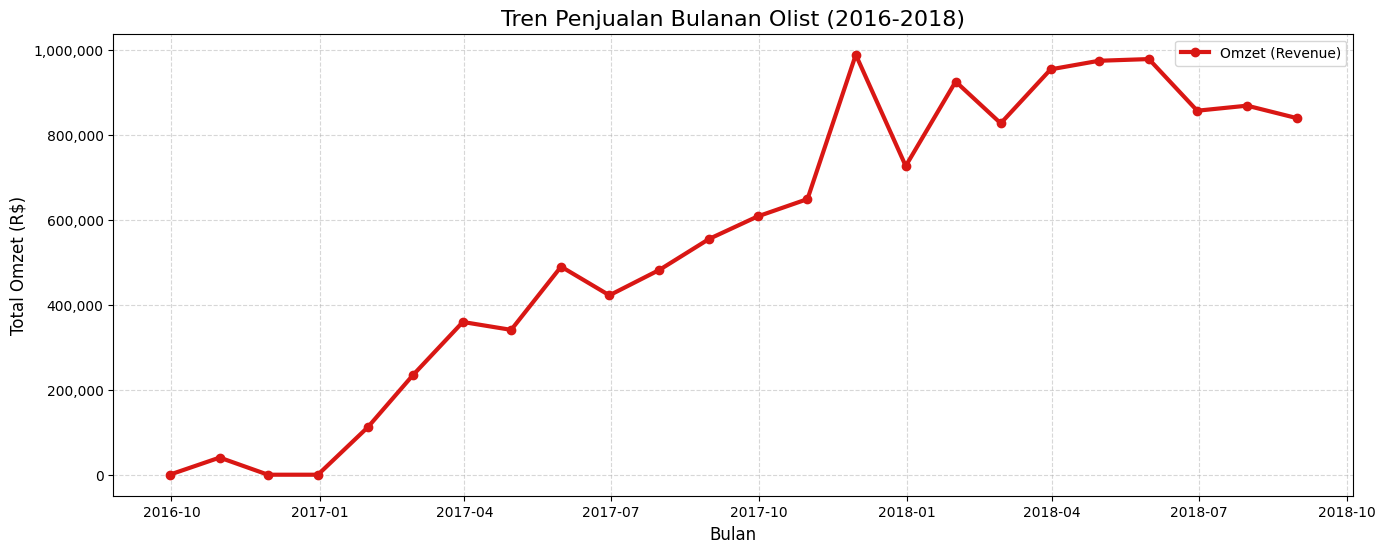

In [132]:
plt.figure(figsize=(16, 6))

plt.plot(monthly_sales.index, monthly_sales['Total_Omzet'], marker='o', color="#d91714", linewidth=3, label='Omzet (Revenue)')

plt.title('Tren Penjualan Bulanan Olist (2016-2018)', fontsize=16)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Total Omzet (R$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

def ribuan(y, pos):
    return f'{y:,.0f}'

# Terapkan ke sumbu Y (Y-Axis)
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(ribuan))

plt.show()

3. C. Peta Sebaran (Wins by Region)

- Tujuan: Bos pengen tahu gudang mana yang paling sibuk.
- Kolom yang dipakai: customer_state (Negara Bagian) atau customer_city.
- Target: Bikin Map Chart atau Bar Chart mendatar.



                     price  order_id
customer_state                      
SP              5067633.16     40501
RJ              1759651.13     12350
MG              1552481.83     11354
RS               728897.47      5345
PR               666063.51      4923
SC               507012.13      3546
BA               493584.14      3256
DF               296498.41      2080
GO               282836.70      1957
ES               268643.45      1995


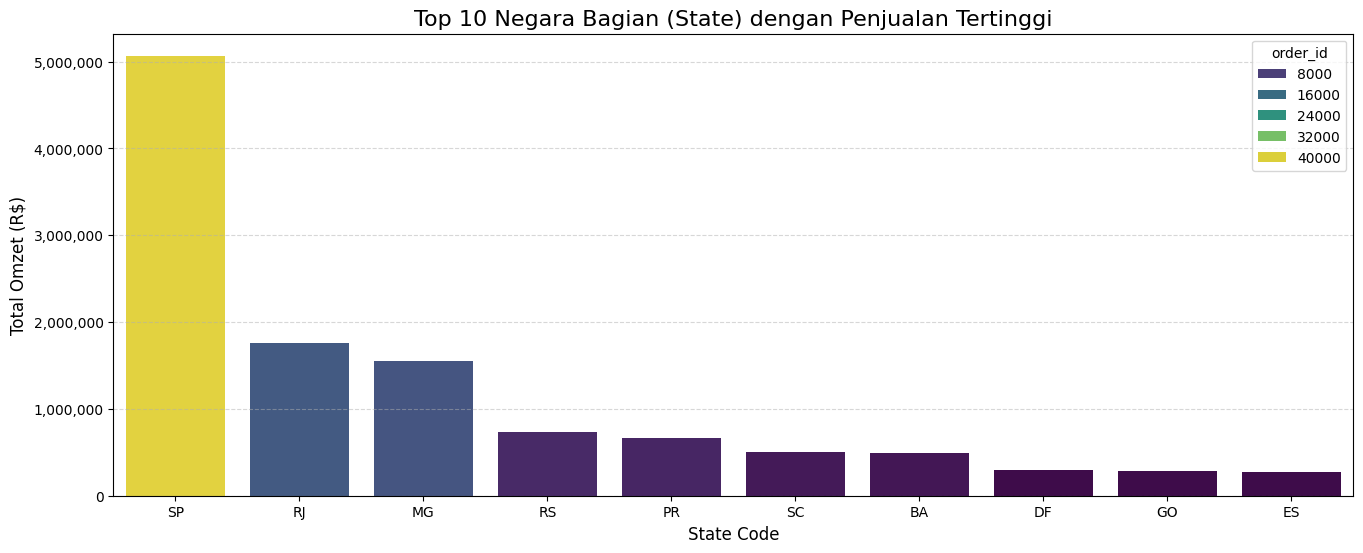

In [133]:
# --- ANALISIS PERSEBARAN WILAYAH (STATE) ---
import seaborn as sns

# Group by State (Negara Bagian)
# SP = Sao Paulo, RJ = Rio de Janeiro, dll.
by_state = df_master_geo.groupby('customer_state').agg({
    'price': 'sum',         # Total Omzet
    'order_id': 'nunique'   # Jumlah Transaksi
}).sort_values(by='price', ascending=False)

# Cek angka
print(by_state.head(10))

# Visualisasi
plt.figure(figsize=(16, 6))

# Top 10 State 
sns.barplot(x=by_state.index[:10], y=by_state['price'][:10], hue=by_state['order_id'][:10], palette='viridis', dodge=False)

plt.title('Top 10 Negara Bagian (State) dengan Penjualan Tertinggi', fontsize=16)
plt.xlabel('State Code', fontsize=12)
plt.ylabel('Total Omzet (R$)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

## fungsi formatter biar angkanya ada koma (ribuan)
def ribuan(y, pos):
    return f'{y:,.0f}'

# Terapkan ke sumbu Y (Y-Axis)
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(ribuan))

plt.show()



4. D. Produk Juara (Top Categories)

- Tujuan: Bos pengen tahu kita jualan apa sih yang paling laku.
- Kolom yang dipakai: category dan price.
- Target: Bar Chart (5 Kategori Teratas).

                category       price  order_id
0          health_beauty  1233131.72      9465
1          watches_gifts  1166176.98      5859
2         bed_bath_table  1023434.76     10953
3         sports_leisure   954852.55      8431
4  computers_accessories   888724.61      7644


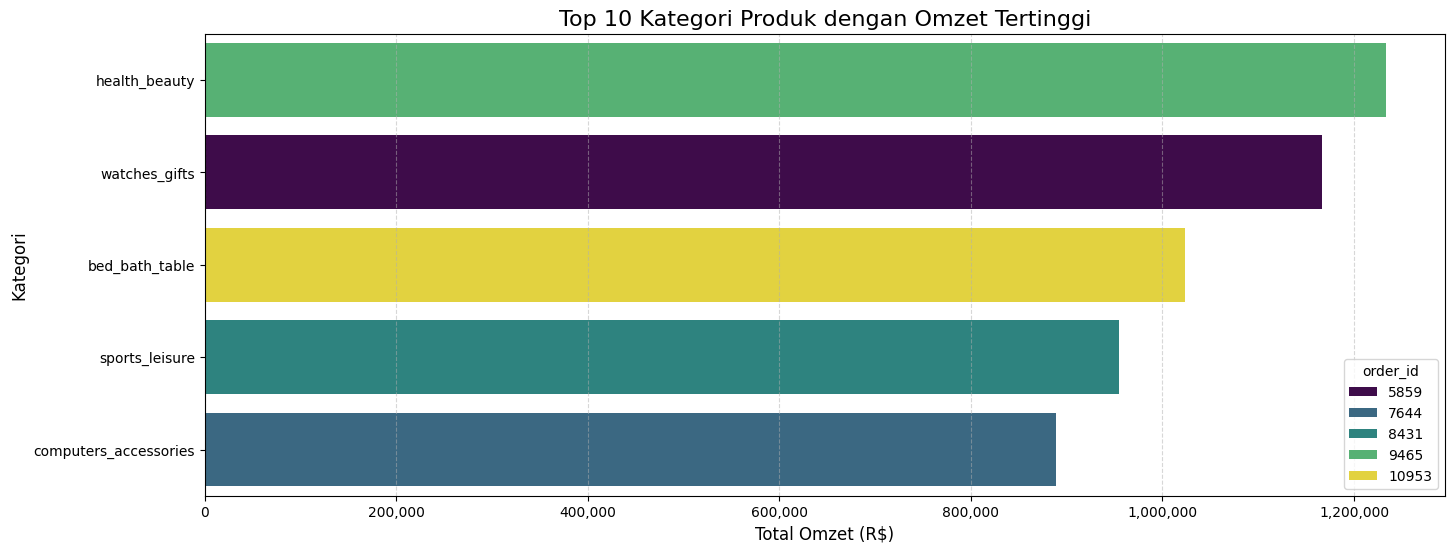

In [134]:
# --- ANALISIS PRODUK TERLARIS ---

# Group by Kategori
# hitung Price (sum) untuk duitnya, dan Order ID (count) untuk jumlahnya
top_products = df_master_geo.groupby('category').agg({
    'price': 'sum',
    'order_id': 'count'  # order_id untuk jumlah terjual
}).sort_values(by='price', ascending=False).reset_index()

# Ambil Top 10 
top_10 = top_products.head(5)

print(top_10)

# Visualisasi (Bar Chart Horizontal)
plt.figure(figsize=(16, 6))

# seaborn biar warnanya otomatis cantik
import seaborn as sns
sns.barplot(x=top_10['price'], y=top_10['category'], hue=top_10['order_id'], palette='viridis', dodge=False)

plt.title('Top 10 Kategori Produk dengan Omzet Tertinggi', fontsize=16)
plt.xlabel('Total Omzet (R$)', fontsize=12)
plt.ylabel('Kategori', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

## fungsi formatter biar angkanya ada koma (ribuan)
def ribuan(x, pos):
    return f'{x:,.0f}'

# Terapkan ke sumbu X
from matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(ribuan))

plt.show()



---

## ANCOVA

**apakah pendapatan per order antar kota berbeda signifikan, SETELAH mengontrol variabel lain (mis. ongkir).**

**Analisis dilakukan pada seluruh kota dengan minimal 35 transaksi untuk memastikan validitas statistik. Selain itu, analisis tambahan difokuskan pada 10 kota dengan volume transaksi tertinggi untuk tujuan interpretasi dan konsistensi dengan dashboard.**

---

In [137]:
df_order = df_master_geo.groupby("order_id").agg({
    "customer_city": "first",
    "price": "sum",
    "freight_value": "sum",
    "order_item_id": "count"
}).reset_index()

df_order.rename(columns={
    "price": "order_revenue",
    "freight_value": "order_freight",
    "order_item_id": "total_items"
}, inplace=True)

print(df_order.head())

                           order_id          customer_city  order_revenue  \
0  00010242fe8c5a6d1ba2dd792cb16214  campos dos goytacazes          58.90   
1  00018f77f2f0320c557190d7a144bdd3        santa fe do sul         239.90   
2  000229ec398224ef6ca0657da4fc703e          para de minas         199.00   
3  00024acbcdf0a6daa1e931b038114c75                atibaia          12.99   
4  00042b26cf59d7ce69dfabb4e55b4fd9        varzea paulista         199.90   

   order_freight  total_items  
0          13.29            1  
1          19.93            1  
2          17.87            1  
3          12.79            1  
4          18.14            1  


In [148]:
city_order_count = df_order.groupby("customer_city")["order_id"].nunique()

valid_cities = city_order_count[city_order_count >= 35].index

df_order_valid = df_order[df_order["customer_city"].isin(valid_cities)]

In [140]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model_clean = smf.ols(
    "order_revenue ~ C(customer_city) + order_freight",
    data=df_order_valid
).fit()

anova_clean = sm.stats.anova_lm(model_clean, typ=2)
print(anova_clean)


                        sum_sq       df             F        PR(>F)
C(customer_city)  2.618419e+07    361.0      1.990778  9.121387e-26
order_freight     5.770177e+08      1.0  15837.255424  0.000000e+00
Residual          2.806162e+09  77020.0           NaN           NaN


**TOP 10**


In [155]:
top10_cities = (
    df_order.groupby("customer_city")["order_id"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_order_top10 = df_order[df_order["customer_city"].isin(top10_cities)]


In [150]:
print("Jumlah kota:", df_order_top10["customer_city"].nunique())
print("Min order per kota:",
      df_order_top10.groupby("customer_city")["order_id"].nunique().min())


Jumlah kota: 10
Min order per kota: 911


In [152]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model_top10 = smf.ols(
    "order_revenue ~ C(customer_city) + order_freight",
    data=df_order_top10
).fit()

anova_top10 = sm.stats.anova_lm(model_top10, typ=2)
print(anova_top10)


                        sum_sq       df            F        PR(>F)
C(customer_city)  4.119793e+06      9.0    13.293070  1.740316e-21
order_freight     2.473912e+08      1.0  7184.171964  0.000000e+00
Residual          1.166781e+09  33883.0          NaN           NaN


In [153]:
mean_freight = df_order_top10["order_freight"].mean()

pred = (
    df_order_top10[["customer_city"]]
    .drop_duplicates()
    .assign(order_freight=mean_freight)
)

pred["adj_mean_revenue"] = model_top10.predict(pred)
pred.sort_values("adj_mean_revenue", ascending=False)


,customer_city,order_freight,adj_mean_revenue
15,campinas,19.784834,143.946446
19,sao paulo,19.784834,140.317925
64,guarulhos,19.784834,138.946508
27,sao bernardo do campo,19.784834,133.568440
148,curitiba,19.784834,128.057039
12,rio de janeiro,19.784834,124.991386
56,brasilia,19.784834,122.101545
54,belo horizonte,19.784834,115.900888
57,porto alegre,19.784834,113.274458
39,salvador,19.784834,98.849208
